In [1]:
# imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import re

from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

import pyLDAvis.gensim_models

import warnings

import plotly_express as px
import datetime

/Users/rfunke/miniforge3/envs/sma/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [2]:
# loading dataframe
df = pd.read_pickle('./bundestag_PMs_filtered.pkl')

# SMA Portfolio Exam 2
## Part 3 - Analysis

We are going to continue the analysis on the previosly filtered dataframe.

In [3]:
# creating dictionary from tokens
dictionary = Dictionary(df.cleaned)

# printing ten most common tokens in dictionary
print(f'Ten most common words:\n{dictionary.most_common(10)}')

# printing original length
print(f'\nTokens in dictionary: {len(dictionary)}')

Ten most common words:
[('parlament', 482), ('ukraine', 198), ('delegation', 157), ('interview', 142), ('abgeordneten', 125), ('eu', 118), ('europäischen', 116), ('russland', 104), ('bundesregierung', 102), ('frage', 100)]

Tokens in dictionary: 14824


In [4]:
# filtering dictionary
dictionary.filter_extremes(no_below=int(len(df)*0.05), no_above=0.25)

# printing length after filtering
print(f'Lenth of dict after filtering: {len(dictionary)}')

Lenth of dict after filtering: 521


As opposed to before, we are going to configure a filter that keep tokens which are contained in at least 5% and in no more than 25% of the documents.

The filtering conditions were established by extensively testing their impact incrementally. An unsuitable filtering might lead to a high coherence score on either a numbre of topics way too low or way to high.

In [5]:
# making corpus from dictionary
corpus = [dictionary.doc2bow(text) for text in df.cleaned]

# Optimal number of topics

In [6]:
# Choose number of topics to maximize topic coherence'

topics = []
coherence = []
for i in range(2, 16):
    # configuring LDA model
    ldamodel = LdaModel(
        corpus=corpus,
        num_topics=i,
        id2word=dictionary,
        iterations=1000,
        alpha='auto',
        random_state=1,
        passes=5)
    
    # calculating coherence score for each number of topics
    u_mass = CoherenceModel(
        model=ldamodel,
        corpus=corpus,
        dictionary=dictionary,
        coherence='u_mass')

    topics.append(i)
    coherence.append(u_mass.get_coherence())

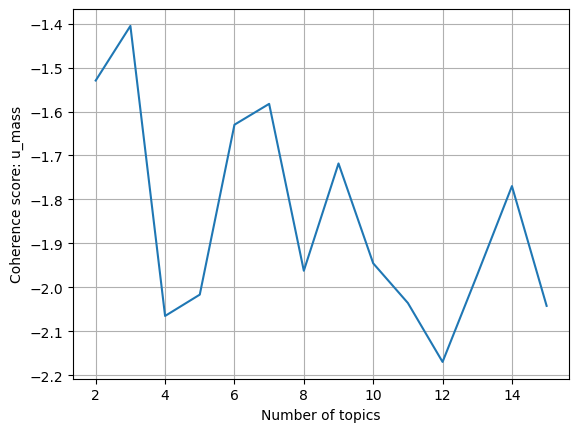

In [7]:
# Create a figure and axes
fig, ax = plt.subplots()

plt.xlabel('Number of topics')
plt.ylabel('Coherence score: u_mass')

# Plot the data
ax.plot(topics, coherence)

# Turn on grid lines
ax.grid(True)

# Show the plot
plt.show()

Eventhough the model with three topics has scored the highest coherence score, seven topics scored the second highest coherence score. In the interest of granularity, we are going to proceed with seven topics.

## Run LDA Algorithm

In [8]:
# settings number of topics
num_topics=7

# configuring LDA model
lda = LdaModel(
    corpus=corpus,
    num_topics=num_topics,
    id2word=dictionary,
    iterations=5000,
    alpha='asymmetric',
    passes=25,
    eval_every=1,
    random_state=1)

## Interpretation

In [9]:
# getting 15 most common words per topic
topics_list = []
for topic in np.arange(num_topics):
    topics_list.append(lda.show_topic(topic, topn=25))

# printing 15 most common words per topic
for i in range(len(topics_list)):
    probs = pd.DataFrame(topics_list[i], columns =['Word', 'Probability']) 
    probs = probs.sort_values('Probability', ascending=False)
    probs = probs.style.set_caption(f'TOPIC {i}')
    display(probs)

,Word,Probability
0,russland,0.018299
1,frage,0.015403
2,interview,0.013459
3,unternehmen,0.012764
4,nächsten,0.010245
5,berlin,0.010211
6,sehen,0.009773
7,verfahren,0.009111
8,lassen,0.008635
9,wahl,0.008624


,Word,Probability
0,ukraine,0.062778
1,bundestagspräsidentin,0.029660
2,bas,0.028852
3,eu,0.021875
4,nato,0.019381
5,russland,0.018418
6,konferenz,0.017342
7,russischen,0.017065
8,parlamente,0.015655
9,bärbel,0.014957


,Word,Probability
0,bundesregierung,0.022267
1,interview,0.021397
2,frage,0.014541
3,nächsten,0.014401
4,geben,0.012963
5,wochenzeitung,0.012059
6,euro,0.011752
7,erscheinungstag,0.011085
8,milliarden,0.010386
9,prozent,0.009270


,Word,Probability
0,pandemie,0.027665
1,kinder,0.020099
2,interview,0.014821
3,eu,0.013407
4,union,0.013306
5,bundesregierung,0.012815
6,wochenzeitung,0.012702
7,fraktion,0.009845
8,erscheinungstag,0.009721
9,milliarden,0.009350


,Word,Probability
0,arbeiten,0.021353
1,arbeit,0.017790
2,brauchen,0.013757
3,informationen,0.012919
4,bund,0.012684
5,legislaturperiode,0.012245
6,parlamentarischer,0.011905
7,lernen,0.011437
8,parlamentarismus,0.011267
9,demokratie,0.011133


,Word,Probability
0,kinder,0.022070
1,gesellschaft,0.022061
2,europa,0.018710
3,konferenz,0.017241
4,zukunft,0.016441
5,demokratie,0.015161
6,politik,0.014857
7,kinderkommission,0.014559
8,erklärt,0.012687
9,europas,0.011894


,Word,Probability
0,gespräche,0.030323
1,vertretern,0.026623
2,ausschusses,0.023686
3,zusammenarbeit,0.021854
4,ausschuss,0.017664
5,reist,0.017324
6,reise,0.016735
7,politischen,0.016049
8,zudem,0.014659
9,gesprächen,0.014018


In [10]:
# storing document topics
document_topics = lda.get_document_topics(corpus,  minimum_probability=0)

# sorting document topic
sorted_doc_topics = [
    sorted(doc, key=lambda x:x[1], reverse=True) for doc in document_topics]

# adding topic number plus one to keep uniform with Intertopic Distance Map
df['topic'] = [doc[0][0] +1 for doc in sorted_doc_topics]

At this point we change the indexing of the topics, to start with 1 rather than 0. This is to keep the indexing uniform with the gensim LDA visualization of the Intertopic Distance Map.

# Plotting topics

In [11]:
df_viz3 = df.copy()

# duplicating topic column, renaming to topic_name
df_viz3['topic_nr'] = df.loc[:, 'topic']

# replacing duplicated topic numbers with names
df_viz3.topic_nr = df_viz3.topic_nr.replace({
    1: 'Topic 1',
    2: 'Topic 2',
    3: 'Topic 3',
    4: 'Topic 4',
    5: 'Topic 5',
    6: 'Topic 6',
    7: 'Topic 7'
    })
df_viz3

,date,title,text,url,cleaned,topic,topic_nr
0,2022-09-08,Tagung der Vorsitzenden und stellvertretenden ...,"\nZeit:\n Montag, 12. September 2022,\n ...",https://www.bundestag.de/presse/pressemitteilu...,"[hessischer, landtag, medienraum, petitionsaus...",7,Topic 7
1,2022-06-24,Delegation des Ausschusses für Klimaschutz und...,Norwegen ist vom 27. bis zum 29. Juni 2022 das...,https://www.bundestag.de/presse/pressemitteilu...,"[norwegen, ziel, reise, delegation, ausschusse...",7,Topic 7
2,2021-02-11,Kinderkommission zum Red Hand Day am 12. Febru...,Der Red Hand Day am 12. Februar ist in vielen ...,https://www.bundestag.de/presse/pressemitteilu...,"[red, hand, day, ländern, aktionstag, missbrau...",6,Topic 6
3,2022-06-09,Ausschuss für Digitales informiert sich in Est...,Eine Delegation des Ausschusses für Digitales ...,https://www.bundestag.de/presse/pressemitteilu...,"[delegation, ausschusses, digitales, reist, es...",7,Topic 7
4,2023-01-02,„Das Parlament“ - Interview mit Prof. Johannes...,"Prof. Johannes Vogel, Generaldirektor des Muse...",https://www.bundestag.de/presse/pressemitteilu...,"[prof, johannes, vogel, generaldirektor, museu...",3,Topic 3
...,...,...,...,...,...,...,...
216,2021-05-27,Anlässlich des gemeinsamen Treffens des Montec...,Die Ausschüsse für die Angelegenheiten der Eur...,https://www.bundestag.de/presse/pressemitteilu...,"[ausschüsse, angelegenheiten, europäischen, un...",6,Topic 6
217,2021-06-11,„Mehr Ehrlichkeit“Lisa Badum im Interview mit ...,Vorabmeldung zu einem Interview in der nächste...,https://www.bundestag.de/presse/pressemitteilu...,"[vorabmeldung, interview, nächsten, ausgabe, w...",3,Topic 3
218,2022-01-11,Bundestagspräsidentin Bas würdigt David Sassol...,Zum Tod des Präsidenten des Europäischen Parla...,https://www.bundestag.de/presse/pressemitteilu...,"[tod, präsidenten, europäischen, parlaments, d...",2,Topic 2
219,2022-09-30,Der Freundeskreis Berlin-Taipei besucht Taiwan,Vom 1. bis 7. Oktober 2022 reist eine Delegati...,https://www.bundestag.de/presse/pressemitteilu...,"[reist, delegation, freundeskreises, berlin-ta...",7,Topic 7


In [12]:
# counting number of press releases per topic

# to prevent depreciation warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fig = px.pie(df_viz3.topic_nr.value_counts(), values=df_viz3.topic_nr.value_counts().values,
        names=df_viz3.topic_nr.value_counts().index, hole=0.236,
        height=600,
        title='Topic Distribution')
    
    fig.update_traces(textposition='inside', textinfo='percent+label', showlegend=False)
    fig.show()

In [13]:
# sample headlines per topic
display_length = pd.get_option('display.max_colwidth')
pd.set_option('display.max_colwidth', None)
df_viz = df.groupby(['topic'])[['topic','title']].sample(13)

for i in range(1, 8):
    df_viz2 = df_viz[df_viz.topic == i][['title']]
    df_viz2 = df_viz2.style.set_caption(f'TOPIC {i}')
    display(df_viz2)

,title
206,"„Nicht überhitzt handeln“Die stellvertretende Vorsitzende der SPD-Fraktion, Verena Hubertz, im Interview mit der Wochenzeitung „Das Parlament“"
215,Brandenburgs Wirtschaftsminister Steinbach: Geschwindigkeit der Tesla-Ansiedlung ist Vorbild für Aufbau von LNG-Terminals
103,„Drei plus drei wäre die richtige Antwort“Der CDU-Abgeordnete Klaus Wiener im Interview mit der Wochenzeitung „Das Parlament“
76,Ruf nach Neuordnung des Wahlprüfungsverfahrens wird lauter
61,"„Warme Worte alleine reichen eben nicht“Der Vorsitzende des Wirtschaftsausschusses, Michael Grosse-Brömer (CDU), im Interview mit der Wochenzeitung „Das Parlament“"
190,Vorabmeldung zu einem Interview in der nächsten Ausgabe der Wochenzeitung „Das Parlament“ (Erscheinungstag: 12. September 2022)
83,Bundestagspräsidentin Bas dringt auf rechtzeitige Wahlrechtsreform
96,Deutscher Bundestag wählt Evelyn Zupke zur ersten „Bundesbeauftragten für die Opfer der SED-Diktatur beim Deutschen Bundestag“
209,„Die Gelder fließen“Sabine Poschmann (SPD) im Interview mit der Wochenzeitung „Das Parlament“
176,"Schnell, pünktlich und ohne Kostensteigerungen – Kubicki beim Bezug des ersten Bundestagsmodulbaus durch Abgeordnete"


,title
67,Bundestag bei der Interparlamentarischen Konferenz für Außen- und Sicherheitspolitik in Prag
28,Bundestagspräsidentin Bas reist nach Zagreb zur Parlamentarischen Konferenz der Krim-Plattform
203,Parlamentarische Versammlung der Union für den Mittelmeerraum am 3. und 4. Dezember 2021 in Brüssel (hybrid)
69,„Kiew ist das unzerstörbare Herz Europas“: virtuelle Fotoausstellung auf der Internetseite des Bundestages
162,Bundestagspräsidentin Bas würdigt die Wahl Annemarie Rengers zur ersten Bundestagspräsidentin vor 50 Jahren
44,Bundestagspräsidentin Bas reist zu Gesprächen nach Brüssel
194,"Bundestagspräsidentin Bas: „Wir stehen an der Seite Litauens, denn es geht um die Sicherheit Europas“"
16,Außerordentliche Konferenz der Parlamentspräsidenten der G7-Staaten und der EU mit der Ukraine
105,„Sind auf gutem Kurs“Ulrich Lechte (FDP) im Interview mit der Wochenzeitung „Das Parlament“
32,4. September: Bundestag öffnet seine Türen zum „Tag der Ein- und Ausblicke“ / Rundgang der Bundestagspräsidentin


,title
196,„Die Konflikte bleiben“ - Bijan Djir-Sarai (FDP) im Interview mit der Wochenzeitung „Das Parlament“
99,„Keine zu frühen Signale“ Tobias Lindner (Bündnis 90/Die Grünen) im Interview mit der Wochenzeitung „Das Parlament“
205,"Peter Liese, Europaabgeordneter der EVP, fordert von den Mitgliedstaaten, ihre verhärteten Fronten beim Impfzertifikat aufzugeben"
154,"„Eigene Akzente gesetzt“ – Sven-Christian Kindler, haushaltspolitischer Sprecher der Grünen-Fraktion, im Interview mit der Wochenzeitung „Das Parlament“"
107,Thomae (FDP) im Interview mit „Das Parlament“: Vorrang für Einwanderungsgesetz
144,„Das Parlament“: Grünen-Innenexperte Notz mahnt nach „Reichsbürger“-Razzia zu weiterer Wachsamkeit
172,"Wolfgang Strengmann-Kuhn, Sozialexperte der grünen Bundestagsfraktion, fordert eine Neuberechnung der Regelsätze auch beim Bürgergeld"
59,Rohde (SPD) im Interview mit „Das Parlament“: Erneutes Aussetzen der Schuldenbremse möglich
192,Sebastian Brehm (CSU): Regierung wird zum Totengräber des Mittelstands
137,„Nur der erste Schritt“ - Johann Wadephul (CDU) im Interview mit der Wochenzeitung „Das Parlament“


,title
45,Der Grünen-Gesundheitspolitiker Janosch Dahmen hält Lockerungen bei einer Inzidenz von 100 für „Wahnsinn“
112,"Der Kinderarzt Jörg Dötsch setzt beim Impfen vor allem auf Überzeugung, kann den Wunsch nach einer Corona-Impfpflicht aber nachvollziehen"
86,Der FDP-Gesundheitspolitiker Andrew Ullmann fordert Auflagen für den ÖPNV und mehr Schutz für Ältere
39,„Das ist keine nachhaltige Haushaltspolitik“: Unions-Fraktionschef Brinkhaus kritisiert geplanten Nachtragshaushalt der Ampel-Koalition
138,Das Kunstprogramm zum Tag der Ein- und Ausblicke am 4. September im Bundestag
13,Buschmann warnt vor überzogenen Einschränkungen von Grundrechten
111,„Ein absurder Vorgang“Haushalts-Expertin Gesine Lötzsch (Die Linke) im Interview mit der Wochenzeitung „Das Parlament“
169,Interview mit „Das Parlament“/Nach EuGH-Urteil: SPD-Innenpolitiker Lars Castellucci spricht sich für IP-Speicherung aus
82,Linke will schärfere Regeln für Nebentätigkeiten von Abgeordneten
55,„Durch Verträge gedeckt“Eckhardt Rehberg (CDU) im Interview mit der Wochenzeitung „Das Parlament“


,title
80,Daniela Rosenthal wird neue Abteilungsleiterin Information und Dokumentation beim Deutschen Bundestag
58,Schäuble sieht in neuem Bundestag Zeichen der gesellschaftlichen Vielfalt
81,"„Das Angebot bricht in weiten Teilen weg“ - Die tourismuspolitische Sprecherin der CDU/CSU-Fraktion, Anja Karliczek, im Interview mit der Wochenzeitung „Das Parlament“"
161,Parlamentarisches Freilichtkino an der Spree
52,Bundestagspräsident Schäuble würdigt Johannes Gerster als einen unermüdlichen Botschafter für Aussöhnung und Partnerschaft
140,Bundestagspräsidentin Bas prämiert „Handy-Jahre einer Kanzlerin“ mit dem Medienpreis 2022
6,Quadriga-Schauwerkstatt im Mauer-Mahnmal empfängt wieder Besucher ab 22. Juni
20,Zur Reichstagskuppel auf den Hallmarkt: Bundestag präsentiert seine Arbeit beim Tag der Deutschen Einheit in Halle (Saale)
22,Der CDU-Abgeordnete Tebroke dringt auf den schnelleren Ausbau digitaler Infrastruktur auf dem Land
12,Medienpreis Parlament 2022 des Deutschen Bundestages: Jury nominiert Beiträge – Preisverleihung am 12. Oktober 2022


,title
64,Schäuble und polnischer Vizeministerpräsident Gowin für gemeinsame europäische Impfstrategie
54,Kinderkommission zum Internationalen Tag der Kinderrechte am 20. November
171,Kinderkommission zum Tag der vermissten Kinder am 25. Mai 2021
27,Bundestagspräsident Schäuble begrüßt den Auftakt der Konferenz zur Zukunft Europas | Europäische Parlamentspräsidenten beraten heute über Zusammenhänge zwischen Digitalisierung und Demokratie
130,Schäuble würdigt Christian Boltanski als „Meister der Erinnerung“
173,"Ausschuss für Bildung, Forschung und Technikfolgenabschätzung besucht die Europäischen Institutionen in Brüssel"
197,„Gemeinsam einzigartig“Kinderkommission zum bundesweiten Vorlesetag am 18. November 2022
63,Kinderkommission zum Weltspieltag am 28. Mai 2022: „Politik und Verwaltung müssen den Kinderrechten bei ihren Entscheidungen Raum geben“
91,"Kinderkommission zum Internationalen Tag der Jugend 2021: „Es muss eine Selbstverständlichkeit sein, dass junge Menschen an politischen Entscheidungsprozessen teilhaben“"
129,„Jede Stimme zählt!“ – Bundestagspräsident Schäuble ruft zur Teilnahme an der Bundestagswahl am 26. September auf


,title
90,Bundestag präsentiert seine Arbeit beim Tag der Deutschen Einheit in Erfurt
109,Unterausschuss des Auswärtigen Ausschusses für Internationale Klima- und Energiepolitik reist nach Indien
73,Wahlprüfungsausschuss reist nach Estland
219,Der Freundeskreis Berlin-Taipei besucht Taiwan
47,Ausschuss für wirtschaftliche Zusammenarbeit und Entwicklung reist nach Indonesien und Osttimor
125,Entwicklungsausschuss in Kolumbien und Bolivien
18,Ausschuss für Menschenrechte reist nach Taiwan und Japan
11,Bundestagsausschuss für wirtschaftliche Zusammenarbeit und Entwicklung in Malawi und Südafrika
1,Delegation des Ausschusses für Klimaschutz und Energie besucht vom 27. bis 29. Juni 2022 Norwegen
17,"Parlamentarische Versammlung des Europarates debattiert Recht auf sichere, gesunde und nachhaltige Umwelt"


Looking at some samples of titles in each topic additionally to the most common words can provide a better understanding.

In [14]:
# reverting settings from cell above
pd.set_option('display.max_colwidth', display_length)

## Intertopic Distance Map

In [15]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    # plotting Intertopic Distance Map
    lda_viz = pyLDAvis.gensim_models.prepare(topic_model=lda, corpus=corpus, dictionary=dictionary, sort_topics=False)

pyLDAvis.display(lda_viz)

/Users/rfunke/miniforge3/envs/sma/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/rfunke/miniforge3/envs/sma/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/rfunke/miniforge3/envs/sma/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/rfunke/miniforge3/envs/sma/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/rfunke/miniforge3/envs/sma/lib/python3.9/

Based on the visualization and the sampled headlines per topic we can try to attach some sort of topic name or topic title to each topic number.

Topic 1: 'Interviews: Domestic policy and Russia',\
Topic 2: 'Foreign policy, political conferences',\
Topic 3: 'Interviews: Government and society',\
Topic 4: 'Interviews: Pandemic',\
Topic 5: 'Media & Science Awards',\
Topic 6: 'Childrens\' interests',\
Topic 7: 'Delegation work'

In [16]:
# duplicating topic column, renaming to topic_name
df['topic_name'] = df.loc[:, 'topic']

# replacing duplicated topic numbers with names
df.topic_name = df.topic_name.replace({
    1: 'Interviews: Domestic policy and Russia',
    2: 'Foreign policy, political conferences',
    3: 'Interviews: Government and society',
    4: 'Interviews: Pandemic',
    5: 'Media & Science Awards',
    6: 'Childrens\' interests',
    7: 'Delegation work'
    })

## Topic development over time

In [17]:
# plotting topic development over time
df_test = df.copy()

df_test = df[['date', 'topic_name', 'url']].groupby([pd.Grouper(key='date', freq='M'), 'topic_name']).count()
df_test2 = df_test.reset_index().pivot(index='date', columns='topic_name', values='url')

# to prevent depreciation warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    fig = px.area(df_test2,
            title='Topics over time',
            labels={
                'topic_name': 'Topic',
                'date': 'Date',
                'value': 'Number of releases'
                })

    fig.add_vrect(x0="2021-07-09", x1="2021-09-26", 
            annotation_text="Election Campaigning", annotation_position="top right",
            fillcolor="green", opacity=0.2, line_width=0)

    fig.add_vrect(x0="2021-10-01", x1="2021-12-06", 
            annotation_text="Coalition Negotiations", annotation_position="top left",
            fillcolor="green", opacity=0.2, line_width=0)
            
    fig.add_vline(x=datetime.datetime(2022,2,24).timestamp() * 1000,
            line_width=2, line_dash="dot", line_color="red",
            annotation_font_color="red",
            annotation_position="bottom right",
            annotation_text="Invasion Ukraine")

    fig.show()

In [18]:
# counting number of press releases per topic name

# to prevent depreciation warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fig = px.pie(df.topic_name.value_counts(), values=df.topic_name.value_counts().values,
        names=df.topic_name.value_counts().index, hole=0.236,
        height=550,
        title='Topic Distribution')
    fig.update_traces(textposition='outside', textinfo='percent+label', showlegend=False)

    fig.show()

# Conclusion

When we plot the development of each topic over time we can observer some trends and developments: 
- a period of fewer press release prior to the federal election lasting until the formation of the new government
- a strong increase in communications work with the new government and the invasion of Ukraine
- some topics remain constant: 'Childern's Interests'
- other topics are cyclical: 'Delegation work', 'Media & Science Awards' and 'Foreign policy, politcal conferences'

The naming and description, was done to the best of our abilities though we recommend to have a domain specialist analyse the topic contents again. As there surely are details in the politcal landscape that we are not aware of.

In regards to the objective of extracting prevelant topics and analysing their development over time, we can clearly discern different topics. We can also see how the time of year and where we are in a federal election term has an effect on the topics and to which intensity these are publicized by the parliament.

If our performance for this work order was satisfactory to our customer and we were to consult on how to follow up on the work so far, we would suggest a similar approach to scrape more press release from further sources. These could be for example the press releases of the german government, the ministry for domestic policy and other ministries. As well as the parties represent in parliament. With that data we explore which topics are pushed in different way by the various players within the politcal landscape.